<a href="https://colab.research.google.com/github/GamelinAl/mbtrack2_examples/blob/main/mbtrack2_cavity_resonator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook introduces different classes for **mbtrack2** dealing with RF cavities and longitudinal beam dynamics:

* The `RFCavity` class is a very simple class using in tracking to model RF cavities using a perfect cosine wave.

* The `CavityResonator` class is the main class which can be used to model RF cavities self-consistenly considering beam loading. It can be used in tracking to model:

  *   Active RF cavity
  *   Passive RF cavity
  *   Cavity HOM

  The cavity physics is based on the phasor formalism developped in [1], details of the implementation and benchmark can be found in [2,3].

* The `BeamLoadingEquilibrium` is used to compute analytically the beam equilibrium profile for a given storage ring and a list of RF cavities of any harmonic. The class assumes an uniform filling of the storage ring.

  The implementation is based on an extention of [4] which is detailed in [3].

More advanced features of `CavityResonator`, including different kinds of RF loops and feedbacks, are described in this notebook:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GamelinAl/mbtrack2_examples/blob/main/mbtrack2_cavity_resonator.ipynb)

## Convention
mbtrack2 uses the cosine convention for RF voltage.

## References

[1]  Wilson, P. B. (1994). Fundamental-mode rf design in e+ e− storage ring factories. In Frontiers of Particle Beams: Factories with e+ e-Rings (pp. 293-311). Springer, Berlin, Heidelberg.

[2] Yamamoto, Naoto, Alexis Gamelin, and Ryutaro Nagaoka. "Investigation of Longitudinal Beam Dynamics With Harmonic Cavities by Using the Code Mbtrack." Proc. 10th International Partile Accelerator Conference (IPAC’19), Melbourne, Australia, 19-24 May 2019. 2019.

[3] Gamelin, Alexis, and Naoto Yamamoto. "Equilibrium Bunch Density Distribution with Multiple Active and Passive RF Cavities." 12th International Particle Accelerator Conference. 2021.

[4] Venturini, M. (2018). Passive higher-harmonic rf cavities with general settings and multibunch instabilities in electron storage rings. Physical Review Accelerators and Beams, 21(11), 114404.



# Initialization

## mbtrack2 set-up

In [1]:
! pip install mbtrack2

Cloning into 'mbtrack2'...
remote: Enumerating objects: 3169, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 3169 (delta 101), reused 15 (delta 12), pack-reused 3010 (from 1)
Receiving objects: 100% (3169/3169), 4.97 MiB | 4.89 MiB/s, done.
Resolving deltas: 100% (2163/2163), done.


In [2]:
%cd mbtrack2

/content/mbtrack2


## Define a Synchrotron object

In [3]:
import numpy as np
from mbtrack2.tracking import Synchrotron, Electron
from mbtrack2.utilities import Optics

mbtrack2 version 0.6.0.54
--------------------------------------------------
If used in a publication, please cite mbtrack2 paper and the zenodo archive for the corresponding code version (and other papers for more specific features).
[1] A. Gamelin, W. Foosang, N. Yamamoto, V. Gubaidulin and R. Nagaoka, “mbtrack2”. Zenodo, Mar. 25, 2024. doi: 10.5281/zenodo.10871040.
[2] A. Gamelin, W. Foosang, and R. Nagaoka, “mbtrack2, a Collective Effect Library in Python”, presented at the 12th Int. Particle Accelerator Conf. (IPAC'21), Campinas, Brazil, May 2021, paper MOPAB070.




In [4]:
h = 20 # Harmonic number of the accelerator.
L = 100 # Ring circumference in [m].
E0 = 1.5e9 # Nominal (total) energy of the ring in [eV].
particle = Electron() # Particle considered.
ac = 1e-3 # Momentum compaction factor.
U0 = 200e3 # Energy loss per turn in [eV].
tau = np.array([1e-3, 1e-3, 2e-3]) # Horizontal, vertical and longitudinal damping times in [s].
tune = np.array([12.2, 15.3]) # Horizontal and vertical tunes.
emit = np.array([10e-9, 10e-12]) # Horizontal and vertical equilibrium emittance in [m.rad].
sigma_0 = 15e-12 # Natural bunch length in [s].
sigma_delta = 1e-3 # Equilibrium energy spread.
chro = [2.0, 3.0] # Horizontal and vertical (non-normalized) chromaticities.

In [5]:
local_beta = np.array([3, 2]) # Beta function at the tracking location.
local_alpha = np.array([0, 0]) # Alpha function at the tracking location.
local_dispersion = np.array([0, 0, 0, 0]) # Dispersion function and its derivative at the tracking location.
optics = Optics(local_beta=local_beta, local_alpha=local_alpha,
                  local_dispersion=local_dispersion)

In [6]:
ring = Synchrotron(h=h, optics=optics, particle=particle, L=L, E0=E0, ac=ac,
                   U0=U0, tau=tau, emit=emit, tune=tune,
                   sigma_delta=sigma_delta, sigma_0=sigma_0, chro=chro)

## Define a Beam object

In [7]:
from mbtrack2.tracking import Beam

0.5000000000000001


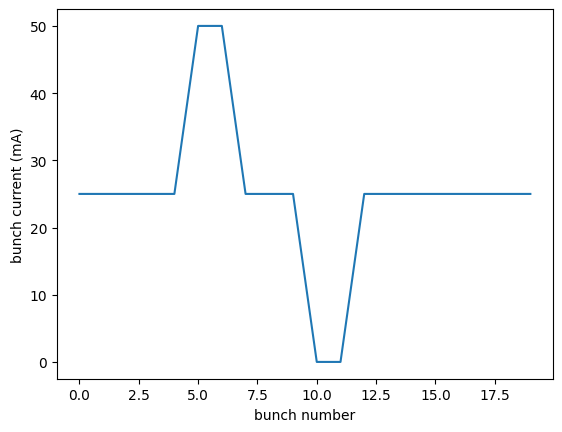

In [8]:
filling_pattern = np.ones(ring.h)*0.025
filling_pattern[5:7] = 0.05
filling_pattern[10:12] = 0
mybeam = Beam(ring)
mybeam.init_beam(filling_pattern, mp_per_bunch=1e3)
fig = mybeam.plot("bunch_current")
print(mybeam.current)

# RFCavity class

The `RFCavity` class is a very simple class to model RF cavities using a perfect cosine wave.

In [9]:
from mbtrack2.tracking import RFCavity

In [10]:
m = 1 # Harmonic number of the cavity
Vc = 1e6 # Total cavity voltage in [V].
theta = np.arccos(ring.U0/Vc) # Total cavity phase in [rad].
RF = RFCavity(ring, m, Vc, theta)

The `track` method of the `RFCavity` class can be called for both `Bunch` and `Beam` elements and simply applies:

$\delta = \delta +  \frac{V_c}{E_0} \cos(m \omega_1 \tau + \theta)$

In [11]:
print(mybeam[0]["delta"][:5])
RF.track(mybeam)
print(mybeam[0]["delta"][:5])

[-0.00070136 -0.00023309 -0.00118755 -0.00025426 -0.00131552]
[-5.77827373e-04 -9.63700266e-05 -1.05731502e-03 -1.24226321e-04
 -1.18057734e-03]


# CavityResonator class
The `CavityResonator` can be used to model:

*   Active RF cavities
*   Passive RF cavities
*   Cavity HOMs

The cavity physics is based on the phasor formalism developped in [1], details of the implementation and benchmark can be found in [2,3].

In [12]:
import matplotlib.pyplot as plt
from mbtrack2.tracking import CavityResonator

Let us define a first `CavityResonator` element, for example to describe the fundamental RF cavity needed for our synchrotron.

In [13]:
m = 1 # Harmonic number of the cavity
Rs = 5e6 # Shunt impedance of the cavity in [Ohm], defined as 0.5*Vc*Vc/Pc.
         # If Ncav = 1, used for the total shunt impedance.
         # If Ncav > 1, used for the shunt impedance per cavity.
Q = 35e3 # Quality factor of the cavity.
QL = 5e3 # Loaded quality factor of the cavity.
detune = -100e3 # Detuing of the cavity in [Hz], defined as (fr - m*ring.f1).
Ncav = 4 # Number of cavities.
MC = CavityResonator(ring, m, Rs, Q, QL, detune, Ncav=Ncav)

From this first input, usual quantities are computed:

In [14]:
print(MC.beta) # Coupling coefficient of the cavity.
print(MC.fr) # Resonance frequency of the cavity in [Hz].
print(MC.psi) # Tuning angle in [rad].
print(MC.filling_time) # Cavity filling time in [s].
print(MC.loss_factor) # Cavity loss factor in [V/C].

6.0
59858491.6
-1.5109593939048
2.6588532192798413e-05
107457712837.44363


The full list of parameter, attribute and method are listed in the class docstring and can be accessed by calling:

```
help(CavityResonator)
```

As this cavity is intented to be an active one, the total voltage and phase must be declared:

In [15]:
MC.Vc = 1e6 # Total cavity voltage in [V].
MC.theta = np.arccos(ring.U0/MC.Vc) # Total cavity phase in [rad].

Then class methods can be used to set the optimal tuning point and computing the generator parameters for a given beam current $I_0$:

In [16]:
I0 = 0.5 # Total multi-bunch current in [A].
MC.set_optimal_detune(I0) # Set detuning to optimal conditions.
print(MC.detune) # Cavity detuning in [Hz] at optimal condition.
MC.set_generator(I0) # Set generator parameters (Pg, Vgr, theta_gr, Vg and theta_g) for a given current and set of parameters.
print(MC.Pg) # Generator power in [W].
print(MC.Vgr) # Generator voltage at resonance in [V].
print(MC.theta_gr) # Generator phase at resonance in [rad].
print(MC.Vg) # Generator voltage in [V].
print(MC.theta_g) # Generator phase in [rad].

-16782.53176803142
126041.66666666666
1571428.5714285714
1.369438406005134
528626.2644652845
0.14173199913728252


The phasor diagram showing the phasor addition of the beam voltage $V_b$ and generator voltage $V_g$ giving the total cavity voltage $V_c$ can be plotted:

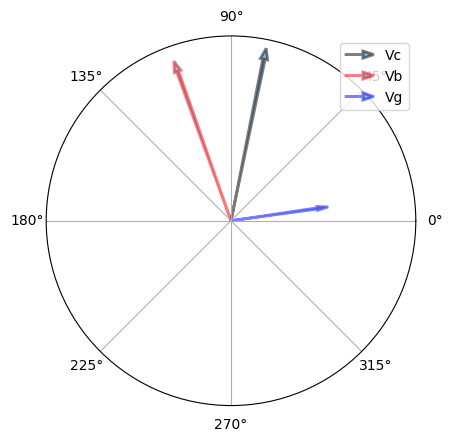

In [17]:
fig = MC.plot_phasor(I0)

The power dissipated in the walls, transmitted to the beam and reflected can be computed:

In [18]:
print(MC.Pc) # Power dissipated in the cavity walls in [W].
print(MC.Pb(I0)) # Return power transmitted to the beam in [W].
print(MC.Pr(I0)) # Return power reflected back to the generator in [W].

25000.0
99999.99999999997
1041.666666666686


The reflected power can be minimized if the cavity coupling is set to the optimal value using the `set_optimal_coupling` method:




In [19]:
MC.set_optimal_coupling(I0) # Set coupling to optimal value.
print(MC.beta) # Coupling coefficient of the cavity.
MC.set_optimal_detune(I0)
MC.set_generator(I0)
print(MC.Pr(I0)) # Return power reflected back to the generator in [W].

4.999999999999998
-1.4551915228366852e-11


The DC Robinson stability (for single RF system) can be checked using the methods `is_DC_Robinson_stable` or `plot_DC_Robinson_stability`:

In [20]:
MC.is_DC_Robinson_stable(I0)

True

False


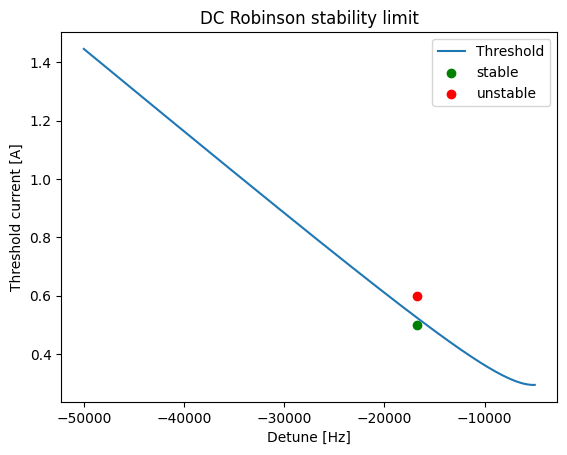

In [21]:
fig = MC.plot_DC_Robinson_stability([-50e3,-5e3])
plt.scatter(MC.detune,I0,c="g")
print(MC.is_DC_Robinson_stable(0.6))
plt.scatter(MC.detune,0.6,c="r")
plt.legend(["Threshold","stable","unstable"])

## Tracking

Tracking using the `CavityResonator` class is based on the `cavity_phasor` which is the phasor sum of:
+ the `generator_phasor` which is fixed by the generator voltage `Vg` and phase `theta_g` attributes:

$$\tilde{V}_{g} = V_{g} e^{j(m \omega_{1} \tau + \theta_{g})}$$

+ the `beam_phasor` which evolves dynamically at each call of the `track` method depending on the macro-particle positions and charges.

The beam phasor $\tilde{V}_b$ is built up by the successive passages of the different particles inside the cavity. Each bunch is binned longitudinally and when a bin of charged particle goes through the RF cavity, it induces a voltage

$$\tilde{V}_0 = -2 k_l q_{mp} N_{mp}$$

Where $k_l$ is the cavity loss factor, $q_{mp}$ is the macroparticle charge, and $N_{mp}$ is the number of macropartiles in the bin.

The voltage induced by the different particles crossing the cavity between time $t$ and time $t + \Delta t$ is added to the voltage $\tilde{V}_{b} (t)$ already present in the cavity at time $t$:

$$
\tilde{V}_{b} (t + \Delta t) = \tilde{V}_{b} (t) e^{-\frac{\Delta t}{\tau_l}}  e^{j\delta_l \Delta t} + \tilde{V}_0 = \tilde{V}_{b} (t) e^{-\frac{\Delta t}{\tau_l}}  e^{j\delta_l \Delta t} -2 k_l q_M
$$

Where $\tau_l$ is the cavity filling time and $\delta_l$ is the phase slippage factor.

As a particle see only half of its wake, the energy change felt by the particles in the bin is:

$$\delta = \delta + \frac{q}{E_0} \left [ Re[\tilde{V}_{g}] + Re[\tilde{V}_{b}] - q_M k_l \right]$$

At the initialization of the `CavityResonator`, the `beam_phasor` attribute is set to zero:

In [22]:
print(MC.beam_phasor) # Beam phasor for tracking in [V]
print(MC.cavity_phasor) # Cavity phasor for tracking in [V]
print(MC.cavity_voltage) # Cavity voltage for tracking in [V]
print(MC.cavity_phase) # Cavity phase for tracking in [rad]

[0.+0.j]
[485714.28571412+46656.94748183j]
[487950.03647412]
[0.0957646]


Depending on the cavity parameters, it can take a long time (especially for super conducting cavities) to fill the cavity and reach the equilibrium beam loading.

To speed-up the cavity filling, one should use the `init_phasor` method before starting the tracking.

In [23]:
MC.init_phasor(mybeam)
print(MC.beam_phasor) # Beam phasor for tracking in [V]
print(MC.cavity_phasor) # Cavity phasor for tracking in [V]
print(MC.cavity_voltage) # Cavity voltage for tracking in [V]
print(MC.cavity_phase) # Cavity phase for tracking in [rad]

[-283883.53096983+933000.63147547j]
[201830.75474429+979657.5789573j]
[1000232.28580621]
[1.3676174]


After the `beam_phasor` initialization, the cavity is filled and the `cavity_voltage` and `cavity_phase` attributes match the objective values `Vc` and `theta` which were set previously.

In [24]:
print(MC.Vc) # Total cavity voltage in [V]. Objective value used in calculations but not in tracking.
print(MC.theta) # Total cavity phase in [rad]. Objective value used in calculations but not in tracking.

1000000.0
1.369438406004566


Once the `beam_phasor` initialization is done, just call the `track` method to update both the beam particle energy deviation $\delta$ and the `beam_phasor`:

In [25]:
print(mybeam[0]["delta"][:5])
print(MC.beam_phasor)
MC.track(mybeam)
print(mybeam[0]["delta"][:5])
print(MC.beam_phasor)

[-5.77827373e-04 -9.63700266e-05 -1.05731502e-03 -1.24226321e-04
 -1.18057734e-03]
[-283883.53096983+933000.63147547j]
[-4.53984817e-04  4.14028612e-05 -9.26763183e-04  6.32551203e-06
 -1.04467636e-03]
[-283883.59547312+932996.4387065j]


The value stored in `beam_phasor` corresponds to the last value of the beam phasor at t=0 (synchronous particle) of the first non empty bunch.

The last value of the beam phasor at t=0 (synchronous particle) of each bunch in stored in the `cavity_phasor_record` attribute.

In [26]:
MC.cavity_phasor_record

array([200036.09194052+979657.20893956j, 200035.60313321+979655.25039183j,
       200035.11019246+979653.61267534j, 200034.61732473+979651.42944194j,
       200034.12008955+979649.43032761j, 198238.96016133+979647.50721553j,
       196444.75883405+979648.24111963j, 196446.19226499+979652.47412264j,
       196447.63284473+979657.47676175j, 196449.08216472+979661.9412014j ,
       198245.20254092+979666.74759656j, 200040.36180403+979668.39429939j,
       200039.89056465+979666.79071288j, 200039.41751214+979665.73673562j,
       200038.94152303+979663.68354521j, 200038.46314288+979661.94427288j,
       200037.98301094+979659.86203178j, 200037.49683581+979658.2088997j ,
       200037.00845764+979656.52444428j, 200036.51880305+979654.88173367j])

## Passive cavity or HOM



A passive (harmonic) cavity or a cavity HOM can be defined in the same way as an active cavity:

In [27]:
m = 4 # Harmonic number of the cavity
Rs = 4.5e9 # Shunt impedance of the cavity in [Ohm], defined as 0.5*Vc*Vc/Pc.
           # If Ncav = 1, used for the total shunt impedance.
           # If Ncav > 1, used for the shunt impedance per cavity.
Q = 1e8 # Quality factor of the cavity.
QL = 1e8 # Loaded quality factor of the cavity.
detune = 25e3 # Detuing of the cavity in [Hz], defined as (fr - m*ring.f1).
HC = CavityResonator(ring, m, Rs, Q, QL, detune)

The induced voltage can be estimated:

In [28]:
HC.Vb(I0) # Beam voltage in [V].

215861.81892505847

If the `CavityResonator` is passive, the **generator voltage** `Vg` and **phase** `theta_g` should **explicitly be set to zero before tracking**:

In [29]:
HC.Vg = 0
HC.theta_g = 0

## Tracking using MPI

MPI can be used to speed up the tracking when using a `Beam` object by distributing the different `Bunch` objects in different cores.

To be able to use this feature, **the python code must be run with as many core as there is of `Bunch` objects in the `Beam`.**

MPI parallelisation can be enabled during ``Beam`` initialization by setting the ``mpi`` option to ``True``:



```
mybeam = Beam(ring)
mybeam.init_beam(filling_pattern, mp_per_bunch=1e3, mpi=True)
```



Compared to the tracking without using MPI, the method `Beam.mpi.share_distributions` must be called before each call of `CavityResonator.track` to compute the bunch profiles and share it between the different cores using MPI.

A typical tracking loop using MPI would then be:



```
MC.init_phasor(beam)
HC.init_phasor(beam)

for i in range(turns):
    
    long.track(beam) # Longitudinal map
    rad.track(beam) # Synchrotron radiation element
    beam.mpi.share_distributions(beam) # Using MPI, this line is needed
    MC.track(beam) # CavityResonator element
    HC.track(beam) # CavityResonator element
```



## CavityMonitor

The `CavityMonitor` can be used to save data from a `CavityResonator` during the tracking.

The follwing attributes are saved:


*   Cavity and Beam phasor for at each bunch
*   Cavity detuning and angle
*   Generator voltage, phase and power
*   Shunt impedance, loaded and unload quality factor



In [30]:
from mbtrack2.tracking.monitors import CavityMonitor, plot_cavitydata

Like the other monitors, the `CavityMonitor` must be initialized before the tracking:

In [31]:
MCmon = CavityMonitor("MC", ring, file_name="tracking_test", save_every=1, buffer_size=10, total_size=100, mpi_mode=False)

The `track` method of `CavityMonitor` takes the `Beam` object as first agrument and the saved `CavityResonator` as second agrument.

In [32]:
from mbtrack2.tracking import LongitudinalMap, SynchrotronRadiation
long = LongitudinalMap(ring)
rad = SynchrotronRadiation(ring)

for i in range(100):
    long.track(mybeam)
    rad.track(mybeam)
    MC.track(mybeam)
    MCmon.track(mybeam, MC)

The saved data can be plotted using the `plot_cavitydata` function:

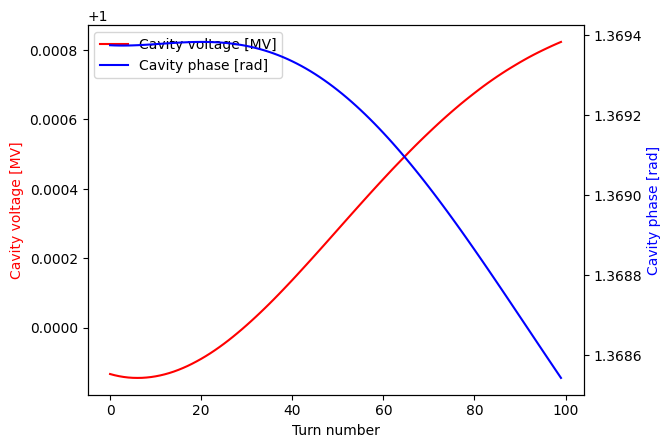

In [33]:
fig = plot_cavitydata("tracking_test.hdf5","MC")

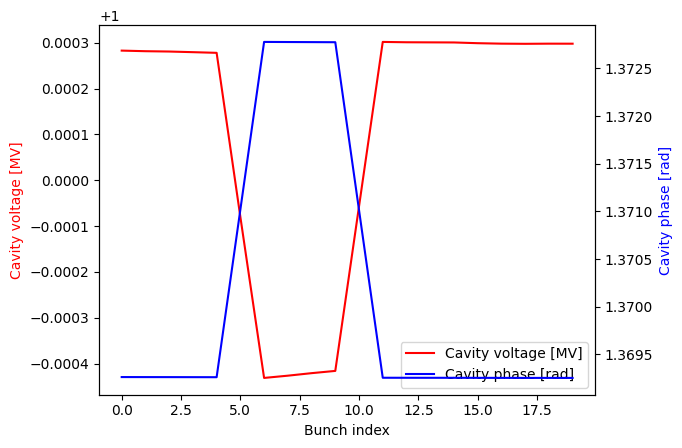

In [34]:
fig = plot_cavitydata("tracking_test.hdf5","MC",plot_type="turn",turn=50)

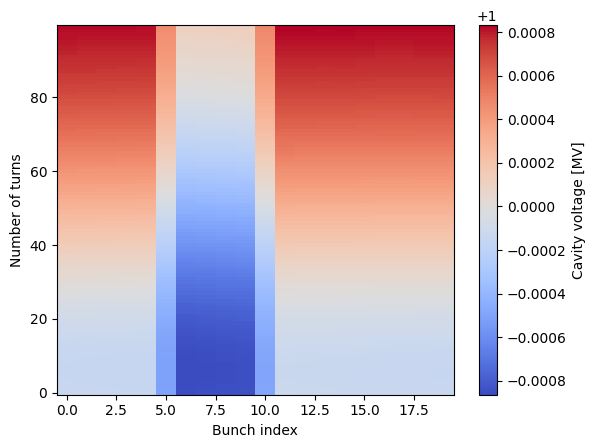

In [35]:
fig = plot_cavitydata("tracking_test.hdf5","MC",plot_type="streak_amplitude")

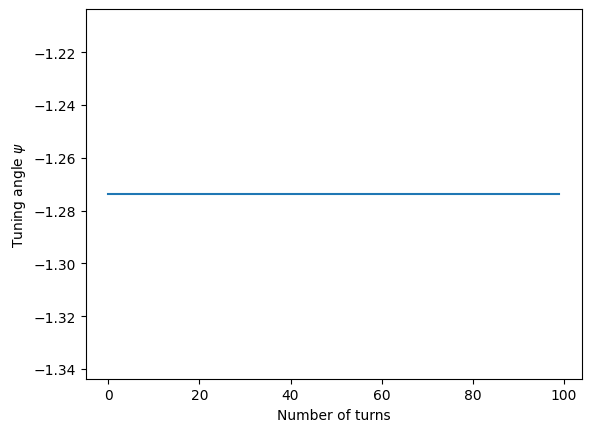

In [36]:
fig = plot_cavitydata("tracking_test.hdf5","MC",plot_type="psi")

# BeamLoadingEquilibrium

The `BeamLoadingEquilibrium` class is used to compute beam equilibrium profile for a given storage ring and a list of RF cavities of any harmonic.

The class assumes an uniform filling of the storage ring and is based on [3,4].

In [37]:
from mbtrack2.utilities import BeamLoadingEquilibrium

For example, we can define a $4^{th}$ harmonic passive cavity and compute the resulting bunch profile from the addition of this new cavity with the active fundamental cavity which was defined earlier from tracking.

To do that, we reuse the same `CavityResonator` class which was used for tracking:

In [38]:
m = 4
Rs = 90e8
Q = 1e8
QL = 1e8
detune = 60e3
HC = CavityResonator(ring, m, Rs, Q, QL,detune)
HC.Vg = 0
HC.theta_g = 0

Then it is possible to define a `BeamLoadingEquilibrium` object to solve using the `beam_equilibrium` method for different harmonic cavity detuning:

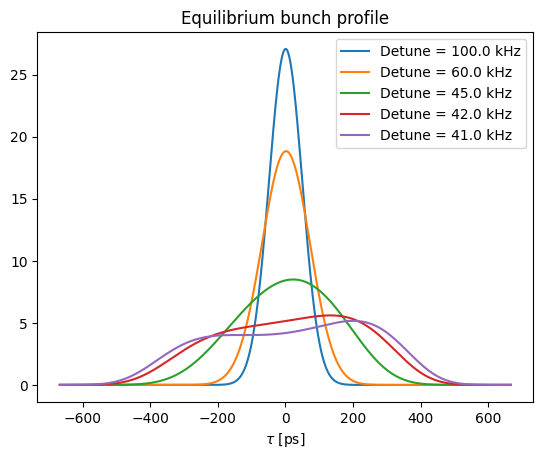

In [40]:
values = np.array([100e3, 60e3, 45e3, 42e3, 41e3])
leg = ["Detune = " + str(val*1e-3) + " kHz" for val in values]
for det in values:
  HC.detune = det
  V = BeamLoadingEquilibrium(ring, [MC,HC], I0, auto_set_MC_theta=False)
  sol = V.beam_equilibrium(plot=False)
  fig = V.plot_rho()
plt.legend(leg)

The equilibrium bunch profile computed analytically using `BeamLoadingEquilibrium` can be compared to the tracking results:

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


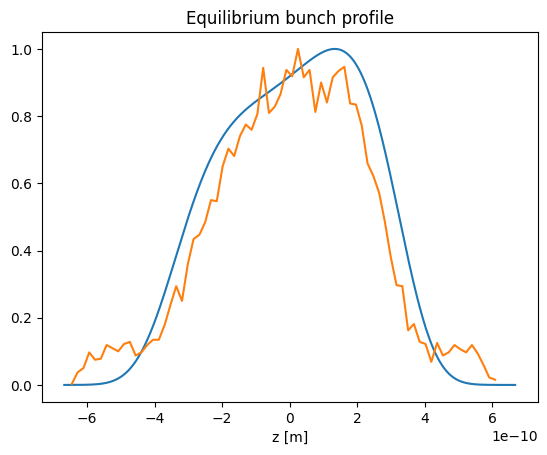

In [41]:
HC.detune = 42e3

# Tracking using a uniform beam filling pattern
filling_pattern = np.ones(ring.h)*I0/ring.h
mybeam = Beam(ring)
mybeam.init_beam(filling_pattern, mp_per_bunch=1e4, track_alive=False)

for i in range(2000):
    if i%100 == 0:
      print(i)
    long.track(mybeam)
    rad.track(mybeam)
    MC.track(mybeam)
    HC.track(mybeam)


# Plot the equilibrium bunch profile
V = BeamLoadingEquilibrium(ring, [MC,HC], I0, auto_set_MC_theta=False)
sol = V.beam_equilibrium(plot=False)
plt.plot(V.tau0, V.rho0/np.max(V.rho0))
plt.xlabel("z [m]")
plt.title("Equilibrium bunch profile")

# Plot the bunch profile of bunch 0 from tracking
bins, sorted_index, profile, center = mybeam[0].binning("tau", 75)
plt.plot(center, profile/max(profile))